Goal: Create tool to validate model-based labels.
Process: 
1. Take prediction for a given video, segment into clips of high and low confidence labels
2. Display clips to user to validate in a input-dependent way such that evidence of poor labeling prompts user to validate more clips
3. Generate a 'score' for each video to indicate if its likely under-, over-, or properly scored and when the improper scoring is occuring
4. Have option to save clips that are definitely one or the other PARTICULARLY if they're incorrectly labeled

Components: 
1. Prediction segmentation: Get average logit for both labels. Smooth logits 

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
logit_file = "/Users/rebeccakrall/Desktop/logits4.pkl"
anns_file = "/Users/rebeccakrall/Desktop/anns4.pkl"
ref = pd.read_csv("/Users/rebeccakrall/Desktop/MoviNet Scratch Model Tests/some_manual_scores_prx03.csv")
vid_directory = "/Users/rebeccakrall/Data/Video Processing and Prediction/Scratching_Projects/PRX_03/PRX_03_Videos"

with open(logit_file, 'rb') as file:
    logits = pickle.load(file)

In [3]:
from scipy import signal
from scipy.ndimage import uniform_filter1d



KeyboardInterrupt: 

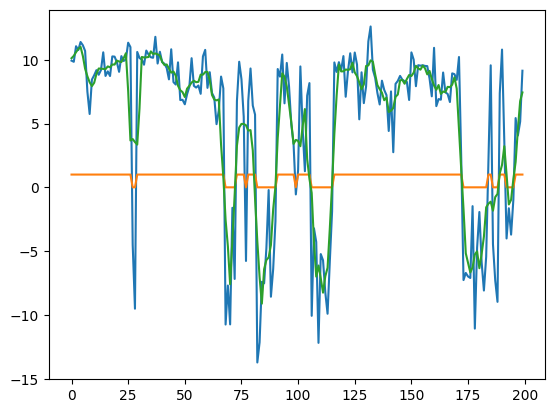

In [9]:
y = np.squeeze(np.array(logits[0]))
y_smooth = signal.savgol_filter(y, 6, 3), # order of fitted polynomial
y_filter = uniform_filter1d(y, size=5)

epoch = 0
plt.plot(y[epoch: epoch+200])
# plt.plot(y_smooth[0][epoch: epoch+200])
plt.plot(y[epoch: epoch+200] > 0 )
plt.plot(y_filter[epoch:epoch+200])


In [10]:
def rolling_analysis(data, window):
    for i in range(len(data)- window):
        avg = np.sum(data[i:i+window])/window
        counts = np.sum(data[i:i+window] < 0)
    

In [11]:
data = y
window = 5
rolling_avg = np.array([np.sum(data[i:i+window])/window for i in range(len(data-window))])
rolling_counts = np.array([np.sum(data[i:i+window] < 0)/window for i in range(len(data-window))])

In [12]:
hc_non = np.where((rolling_avg > 5) & (rolling_counts == 0))
lc_non = np.where((rolling_avg < 2) & (rolling_avg > -2) & (rolling_counts < 0.4))
lc_on = np.where((rolling_avg < 2) & (rolling_avg > -2) & (rolling_counts > 0.6))
hc_on = np.where((rolling_avg < 0) & (rolling_counts == 1))

In [13]:
import random
random.sample(list(hc_non[0]), 10)

[634, 2662, 609, 1376, 708, 561, 1525, 2026, 164, 2215]

In [14]:
# transform logit index into frame
logit_index = 2588
prediction_frames = 20
fps = 30
frame_start = (logit_index * prediction_frames)
frame_end = (logit_index + window) * prediction_frames
time_start = (frame_start/fps)/60

In [15]:
np.array(hc_non) * 20

array([[    0,    20,    40, ..., 53880, 53900, 53920]])

In [16]:
from video_preprocessing import get_params_from_vid, padcrop_image, frame_crop
import cv2

In [17]:
ref.loc[0, 'mouse id']


'm3'

In [18]:
# input video, start & length of clips, labels
starts = np.array(hc_non) * prediction_frames
vid = os.path.join(vid_directory, ref.loc[0,'filepath'])
frames = window * prediction_frames
buffer = 300
dp = 0.5
minDist = 400
animals = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']
an = ref.loc[0, 'mouse id']



In [19]:
class LabeledGenerator:
    def __init__(self, save_path, starts, vid, anns, an, frames, window = 15, buffer = 300, dp = 0.5, minDist = 400):
        """ Returns a set of frames with their associated label. 

        Args:
            videos: list of filepaths 
            save_path: folder to save new clips
            seconds: length of clip in seconds
        """
        self.save_path = save_path
        self.starts = starts
        self.vid = vid
        self.anns = anns
        self.frames = frames
        self.an = an
        self.buffer = buffer
        self.dp = dp
        self.minDist = minDist

        self.current_video = 0
        self.current_animal = 0

    def __iter__(self):

        circles, vid_frames, fps, _ = get_params_from_vid(self.vid)

        cap = cv2.VideoCapture(self.vid)
        self.starts.sort()

        filename = os.path.splitext(os.path.basename(self.vid))[0]

        for s in self.starts:
            print(s)
            cap.set(cv2.CAP_PROP_POS_FRAMES, s)
            print('opened cap')

            result = []
            for ind in range(int(self.frames)):
                
                ret, frame = cap.read()
                center = circles[self.an]

                cc, center = frame_crop(center[0], center[1], buffer = self.buffer, shape = frame.shape[:2])
                pc = padcrop_image(frame, self.buffer, cc, center)

                if self.anns[ind] < 0:
                    cv2.putText(pc, "scratching", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

                result.append(pc)
                    
            # result = np.array(result)
            details = {'filename': filename, 'animal': self.an, 'frames': (s, int(s+(self.frames))), 'fps': fps, 'shape':frame.shape}
            yield result, details
        
        cap.release()

In [3]:
ref.loc[0,'Video Start Time']
# ref.columns

NameError: name 'ref' is not defined

In [21]:
save_path = "/Users/rebeccakrall/Desktop/Model Validation 121024"
starts = random.sample(list(hc_on[0]), 5)

video_clips = LabeledGenerator(save_path = None, starts = starts, vid = os.path.join(vid_directory, ref.loc[0,'filepath']),  anns = logits[0], an =  ref.loc[0, 'mouse id'], frames =window * prediction_frames)
labels = ['Not scratching', 'scratching']
validations = []
for ind, (v, details) in enumerate(video_clips):
    replay = True
    ind_choice = None
    while replay:
        for frame in v:
            cv2.imshow(f'Clip', frame)
            key = cv2.waitKey(20) & 0xFF
            if key == ord('q'):
                replay = False
            elif key == 32:
                while ind_choice not in [str(i) for i in np.arange(0, len(labels))]:
                    ind_choice = input([f'{ind}: {item}' for ind, item in enumerate(labels)])
                choice = labels[int(ind_choice)]
                print(f'Clip {ind} labeled as {choice}')
                replay = False

    validations.append(choice)    

    # if ind_choice is not None:
    #     output_video_path = os.path.join(save_path, labels[int(ind_choice)], f"{details['filename']}_{details['animal']}_{details['frames'][0]}_{details['frames'][1]}.mp4")
    #     print(output_video_path)
    #     out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), details['fps'], (video_clips.buffer*2, video_clips.buffer*2))
    #     for frame in v:
    #         out.write(frame)
    #     out.release()



    # label = None
    # while label not in potential_behaviors:
    #     label = input(f"Enter label for clip {ind}, \n {[potential_behaviors]}")

# cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

KeyboardInterrupt: 

In [219]:
logits[0]

array([[ 9.929771],
       [ 9.839922],
       [11.059437],
       ...,
       [ 8.266785],
       [ 8.340082],
       [ 8.388367]], dtype=float32)

In [231]:
vid = os.path.join(vid_directory, ref.loc[0,'filepath'])
cap = cv2.VideoCapture(vid)
circles, vid_frames, fps, _ = get_params_from_vid(vid)

for logit in logits[0]:
    for _ in range(20):
        ret, frame = cap.read()
        center = circles['m3']

        cc, center = frame_crop(center[0], center[1], buffer = 300, shape = frame.shape[:2])
        pc = padcrop_image(frame, 300, cc, center)

        if logit < 0:
            cv2.putText(pc, "scratching", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

        cv2.imshow(f'Clip', pc)
        key = cv2.waitKey(33) & 0xFF
        if key == ord('q'):
            break
        #     replay = False
        # elif key == 32:
        #     while ind_choice not in [str(i) for i in np.arange(0, len(labels))]:
        #         ind_choice = input([f'{ind}: {item}' for ind, item in enumerate(labels)])
        #     choice = labels[int(ind_choice)]
        #     print(f'Clip {ind} labeled as {choice}')
        #     replay = False
cv2.destroyAllWindows()
cv2.waitKey(1)

KeyboardInterrupt: 

In [2]:
pc

NameError: name 'pc' is not defined

In [225]:
2700*20

54000

In [230]:
np.array([[x] * 20 for x in logits[0]])

(2700, 20, 1)

In [10]:
np.mean(data[data <0])

-7.381026

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

In [2]:
from model_validation import *

In [3]:
logit_file = "/Users/rebeccakrall/Desktop/logits4.pkl"
anns_file = "/Users/rebeccakrall/Desktop/anns4.pkl"
ref = pd.read_csv("/Users/rebeccakrall/Desktop/MoviNet Scratch Model Tests/some_manual_scores_prx03.csv")
vid_directory = "/Users/rebeccakrall/Data/Video Processing and Prediction/Scratching_Projects/PRX_03/PRX_03_Videos"

with open(logit_file, 'rb') as file:
    logits = pickle.load(file)

In [18]:
inds = [24, 59, 7]
windows = [2,3,4]
num_clips = [5, 10, 15]
repeats = 3

all_results = []
for ind in inds:
    for window in windows:
        for num_clip in num_clips:
            dat = {'ind': ind, 'window': window, 'num_clips': num_clip}
            for i in range(repeats):
                vid = os.path.join(vid_directory, ref.loc[ind,'filepath'])
                logit = logits[ind]
                an = ref.loc[ind, 'mouse id']
                prediction_frames = 20
                # window = 2
                delay_start = ref.loc[ind, 'Video Start Time']
                start_time = time.time()
                _, percent_incorrect = validate_animal(vid, an, logit, prediction_frames, window, delay_start = delay_start, num_clips = num_clip, labels = ['not scratch', 'scratch', 'mixed'])   
                end_time = time.time()

                dat[f'iteration {i} incorect'] = percent_incorrect
                dat[f'iteration {i} time']  = end_time - start_time
            print(dat)
            all_results.append(dat)



{'ind': 24, 'window': 2, 'num_clips': 5, 'iteration 0 incorect': 0.2279874213836478, 'iteration 0 time': 92.19598078727722, 'iteration 1 incorect': 0.37735849056603776, 'iteration 1 time': 71.98145508766174, 'iteration 2 incorect': 2.0518867924528306, 'iteration 2 time': 69.44509387016296}
{'ind': 24, 'window': 2, 'num_clips': 10, 'iteration 0 incorect': 0.39308176100628933, 'iteration 0 time': 133.62062215805054, 'iteration 1 incorect': 0.39308176100628933, 'iteration 1 time': 140.89208602905273, 'iteration 2 incorect': 0.39308176100628933, 'iteration 2 time': 134.28884410858154}
{'ind': 24, 'window': 2, 'num_clips': 15, 'iteration 0 incorect': 0.39308176100628933, 'iteration 0 time': 191.1626398563385, 'iteration 1 incorect': 0.9250524109014674, 'iteration 1 time': 180.00988388061523, 'iteration 2 incorect': 0.39308176100628933, 'iteration 2 time': 180.59615898132324}
{'ind': 24, 'window': 3, 'num_clips': 5, 'iteration 0 incorect': 0.08183306055646482, 'iteration 0 time': 70.88914084

KeyboardInterrupt: 

In [5]:
user_labeled_clips, percent_incorrect = validate_animal(vid, an, logit, prediction_frames, window, delay_start = delay_start, num_clips = 5, labels = ['not scratch', 'scratch', 'mixed'])

In [13]:
ind = 8
window = 2
num_clip = 15
prediction_frames = 20
# window = 2
delay_start = ref.loc[ind, 'Video Start Time']
vid = os.path.join(vid_directory, ref.loc[ind,'filepath'])
logit = logits[ind]
an = ref.loc[ind, 'mouse id']

start_time = time.time()
_, percent_incorrect, pi = validate_animal(vid, an, logit, prediction_frames, window, delay_start = delay_start, num_clips = num_clip, bins = 8, labels = ['not scratch', 'scratch', 'mixed'])   
end_time = time.time()


Evaluating Bin: 0 with 4 videos
Wrong: 4, Total 4
Wrong Count: 4.0
All Count: 4
Evaluating Bin: 1 with 17 videos
Wrong: 14, Total 15
Wrong Count: 19.866666666666667
All Count: 21
Evaluating Bin: 2 with 63 videos
Wrong: 12, Total 14
Wrong Count: 74.72380952380952
All Count: 85
Evaluating Bin: 3 with 26 videos
Wrong: 12, Total 15
Wrong Count: 112.32380952380953
All Count: 132
Evaluating Bin: 4 with 2 videos
Wrong: 2, Total 2
Wrong Count: 168.32380952380953
All Count: 188
Evaluating Bin: 5 with 17 videos
Wrong: 0, Total 15
Wrong Count: 168.32380952380953
All Count: 235
Evaluating Bin: 6 with 343 videos
Wrong: 0, Total 13
Wrong Count: 168.32380952380953
All Count: 578
Evaluating Bin: 7 with 2121 videos
Wrong: 2, Total 15
Wrong Count: 451.25714285714287
All Count: 2700


In [5]:
starts, counts = find_starts_bins(logit, window)

In [9]:
(end_time - start_time)/60

3.312097982565562

In [14]:
print(percent_incorrect)
print(f'{np.round((end_time - start_time)/60)} minutes, {np.round((end_time - start_time)%60)} seconds')

16.713227513227512
4.0 minutes, 4.0 seconds


In [17]:
(percent_incorrect/100) * (30 * 60)

300.83809523809526

: 

In [5]:
starts = find_starts_bins(np.squeeze(logit), 3, bins = 10)

for k,v in starts.items():
    print(len(v))

1
2
5
11
57
50
24
111
1597
504


In [9]:
logit.shape

(2700, 1)

In [22]:
counts

array([   1,    3,    6,   19,  112,  117,   61,  152, 1705,  524])

In [28]:
np.sum((logit <= -32.511032) & (logit < -27.744673))

1

In [20]:
initial2 =pd.DataFrame(all_results)
initial2.to_csv("/Users/rebeccakrall/Desktop/Validation_test_24.csv")

In [26]:
incorrect_avg = np.array(initial2.loc[:, ['iteration 0 incorect','iteration 1 incorect', 'iteration 2 incorect']].mean(axis = 1))

In [28]:
(incorrect_avg/100) * 360

array([3.18867925, 1.41509434, 2.05345912, 0.29459902, 0.29459902,
       0.85433715, 1.46316681, 0.15241321, 0.15241321])

In [58]:
starts= find_starts_by_confidence(logits[0], 3)

In [60]:
v = starts['high_off']

In [75]:
num_clips = 10
start_sample = []
while len(start_sample) < num_clips:
    samp = random.sample(list(v),1)
    if all([abs(x - samp[0]) > window for x in start_sample]):
        start_sample.append(samp[0])

In [76]:
start_sample.sort()

In [77]:
start_sample

[237, 244, 760, 927, 1536, 1756, 1992, 2029, 2033, 2274]

In [18]:
start_time = time.time()

In [19]:
end_time = time.time()

In [20]:
elapsed = end_time - start_time

In [21]:
elapsed

62.649566888809204

In [28]:
f'{int(elapsed/60)} min, {int(elapsed%30)} sec'

'1 minutes, 2 seconds'

In [8]:
logit = logits[0]

In [9]:
avg, counts = rolling_analysis(logit, 3)
off = np.mean(logit[logit > 0])
on = np.mean(logit[logit < 0])

In [10]:
off

7.8852344

In [11]:
on

-7.381026

In [13]:
np.sum(avg < (0.8*on))

191

(array([   3.,    4.,   23.,   94.,  141.,   95.,   72.,  263., 1617.,
         388.]),
 array([-24.33381271, -20.5678978 , -16.80198288, -13.03606701,
         -9.27015209,  -5.50423717,  -1.73832202,   2.02759314,
          5.79350805,   9.55942345,  13.32533836]),
 <BarContainer object of 10 artists>)

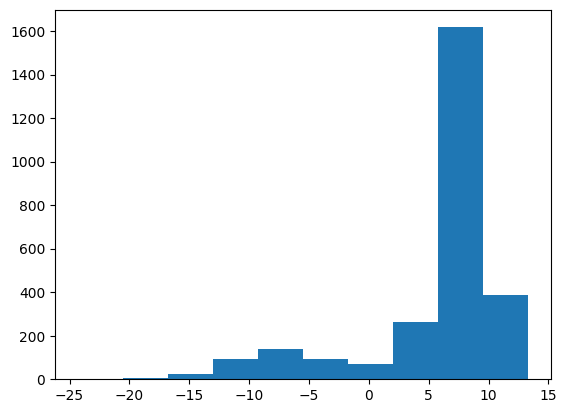

In [15]:
plt.hist(logit)

In [19]:
print(np.sum(counts == 1))
print(np.sum(counts == 0))

243
2150


(array([ 11.,  26.,  70., 108., 174., 409., 676., 442., 197.,  37.]),
 array([ 2.31463559,  3.22577813,  4.13692067,  5.04806321,  5.95920575,
         6.87034829,  7.78149083,  8.69263337,  9.60377591, 10.51491845,
        11.42606099]),
 <BarContainer object of 10 artists>)

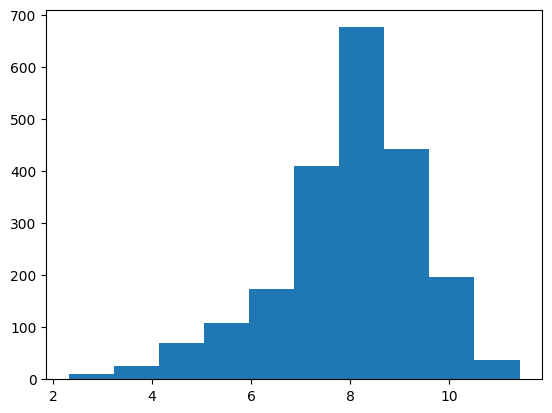

In [20]:
plt.hist(avg[counts == 0])

(array([ 2.,  3., 15., 31., 43., 38., 49., 34., 20.,  8.]),
 array([-16.36389414, -14.86149832, -13.3591025 , -11.85670668,
        -10.35431086,  -8.85191504,  -7.34951922,  -5.8471234 ,
         -4.34472758,  -2.84233176,  -1.33993594]),
 <BarContainer object of 10 artists>)

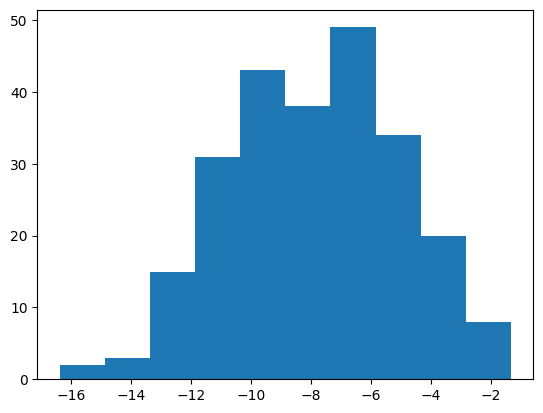

In [21]:
plt.hist(avg[counts == 1])

In [22]:
sampled_elements = random.choices(logits, weights=logits, k=5)


In [134]:
ind = 36
logit = logits[ind]

In [135]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.utils import resample

# Example population: predictions dataframe
data = {
    "prediction": np.squeeze(logit),  # Random predictions from -1 to 1
    "index": np.linspace(0, logit.shape[0], logit.shape[0]).astype(int)
}
population = pd.DataFrame(data)

# 1. Analyze Population Distribution
population["magnitude"] = population["prediction"].abs()
population["normalized_magnitude"] = (population["magnitude"] - population["magnitude"].min())/(population['magnitude'].max() - population['magnitude'].min())
population["sign"] = np.where(population["prediction"] > 0, "positive", "negative")

# 2. Stratify the Population
bins = [0, 0.33, 0.66, 1.0]  # Low, Medium, High confidence
population["confidence_bin"] = pd.cut(population["normalized_magnitude"], bins=bins, labels=["low", "medium", "high"])
strata = population.groupby(["sign", "confidence_bin"])



/var/folders/ch/m9j8_ntd13l1fhyf0w__ydsr0000gp/T/ipykernel_95487/1106585492.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strata = population.groupby(["sign", "confidence_bin"])


In [136]:
def calculate_sample_size(pop_size, confidence_level=0.96, margin_of_error=0.04, p=0.97):
    Z = norm.ppf(1 - (1 - confidence_level) / 2)  # Z-score
    n = (Z**2 * p * (1 - p)) / (margin_of_error**2)
    if pop_size:
        n = n / (1 + (n - 1) / pop_size)  # Finite population correction
    return int(np.ceil(n))

sample_size = calculate_sample_size(len(population))
print(f"Required sample size: {sample_size}")



Required sample size: 75


In [137]:
# 4. Stratified Sampling
sampled = []
for (sign, confidence_bin), group in strata:
    stratum_size = len(group)
    stratum_sample_size = int(sample_size * (stratum_size / len(population)))
    if stratum_sample_size == 0:
        stratum_sample_size = 1
    sampled.append(resample(group, n_samples=stratum_sample_size, replace=False, random_state=42))

sampled_data = pd.concat(sampled)

In [138]:
sampled_data = sampled_data.sort_index()

In [139]:
start_time = time.time()
ind = 36
window = 2
prediction_frames = 20
# window = 2
delay_start = ref.loc[ind, 'Video Start Time']
labels = ['not scratch', 'scratch']
video_path = os.path.join(vid_directory, ref.loc[ind,'filepath'])
logit = logits[ind]
animal = ref.loc[ind, 'mouse id']

circles, vid_frames, fps, _ = get_params_from_vid(video_path)
frame_delay = delay_start * 60 * fps
center = circles[animal]
cap = cv2.VideoCapture(video_path)

# Determine sets of frames of high, medium, and low confidence labeling
start_sample = sampled_data['index']

# Initialize a dictionary to store labeled clips
user_labled_clips ={k: [] for k in labels}


presumed_wrong = 0
all_possible = 0
# iterate through the different 'confidence' levels for each label

wrong = 0
total = 0
# iterate through the clips
for s in start_sample:

    # Determine the clips 'confidence' i.e. proportion of frames labeled 1 
    confidence = sum(logit[s:s+window] < 0) / window ## THIS LINE WILL NEED TO CHANGE IF DOING MULTI-LABEL

    # Get the clip, show it to the user, prompt them to choose 
    clip = grab_clip_with_annotation(cap, s, window, logit, prediction_frames, center, 300, frame_delay, add_text = False)
    user_label = show_clip_grab_input(clip, labels, f'{labels[int(np.round(confidence))]}')

    # if the user actually labeled the clip, determine if it was labeled wrong
    # add it to dictionary of clips
    if user_label:
        total = total + 1
        if int(user_label) != int(np.round(confidence)):
            wrong = wrong + 1

        user_labled_clips[labels[int(user_label)]].append(clip)

    cv2.destroyAllWindows()
    cv2.waitKey(1)

# if len(v):
#     presumed_wrong = presumed_wrong + ((wrong/total) * len(v))
#     all_possible = all_possible + len(v)


cap.release()
# percent_wrong = (presumed_wrong/all_possible) * 100
end_time = time.time()

/var/folders/ch/m9j8_ntd13l1fhyf0w__ydsr0000gp/T/ipykernel_95487/3800614735.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  user_label = show_clip_grab_input(clip, labels, f'{labels[int(np.round(confidence))]}')
/var/folders/ch/m9j8_ntd13l1fhyf0w__ydsr0000gp/T/ipykernel_95487/3800614735.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(user_label) != int(np.round(confidence)):


In [142]:
wrong

0

In [128]:
.19 *360

68.4

In [143]:
elapsed = end_time - start_time

In [144]:
elapsed

172.3893780708313

In [1]:
population

NameError: name 'population' is not defined

In [133]:
14/74

0.1891891891891892